In [1]:
import torch
import numpy as np
from PIL import Image
from torchvision.utils import make_grid
from torch import nn
from torchvision import transforms
from torch.utils import data
import matplotlib.pyplot as plt

import glob
import os

In [2]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 6

In [3]:
ph2_path = '/dtu/datasets1/02514/PH2_Dataset_images/'

class Ph2(data.Dataset):
    def __init__(self, root, transform = None):
        'Initialization'
        self.transform = transform
        self.root = root

        self.image_paths = []
        self.label_paths = []

        for root_, _, files in os.walk(self.root):
            if root_.endswith('_Dermoscopic_Image'):
                self.image_paths.append(os.path.join(root_, files[0]))
            if root_.endswith('_lesion'):
                self.label_paths.append(os.path.join(root_, files[0]))

        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path)
        label = Image.open(label_path)

        if self.transform is not None:
            label = self.transform(label)
            image = self.transform(image)

        sample = {'image': image, 'label': label}
        return sample


class Drive(torch.utils.data.Dataset):
    def __init__(self, root, train, transform = None):
        'Initialization'
        self.transform = transform

        self.root = os.path.join(root, 'training' if train else 'test')

        self.image_paths = []
        self.label_paths = []
        for root_, _, files in os.walk(self.root):
            if root_.endswith('images'):
                [self.image_paths.append(os.path.join(root_, file_)) for file_ in files]
            if root_.endswith('mask'):
                [self.label_paths.append(os.path.join(root_, file_)) for file_ in files]

        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path)
        label = Image.open(label_path)

        if self.transform is not None:
            label = self.transform(label)
            image = self.transform(image)

        sample = {'image': image, 'label': label}
        return sample
    

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

# Load ph2 dataset    
ph2_dataset = Ph2(root=ph2_path, transform=transform)
ph2_train, ph2_val, ph2_test = torch.utils.data.random_split(ph2_dataset, [0.64, 0.16, 0.2], generator=torch.Generator().manual_seed(42))
print('PH2 dataset split images:')
print(f'Train: {len(ph2_train)} \t Val: {len(ph2_val)} \t Test: {len(ph2_test)}')

# Load drive dataset
drive = Drive(root='/dtu/datasets1/02514/DRIVE/', train=True, transform=transform)
drive_test = Drive(root='/dtu/datasets1/02514/DRIVE/', train=False, transform=transform)
drive_train, drive_val = torch.utils.data.random_split(drive, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
print('DRIVE dataset split images:')
print(f'Train: {len(drive_train)} \t Val: {len(drive_val)} \t Test: {len(drive_test)}')

PH2 dataset split images:
Train: 128 	 Val: 32 	 Test: 40
DRIVE dataset split images:
Train: 16 	 Val: 4 	 Test: 20


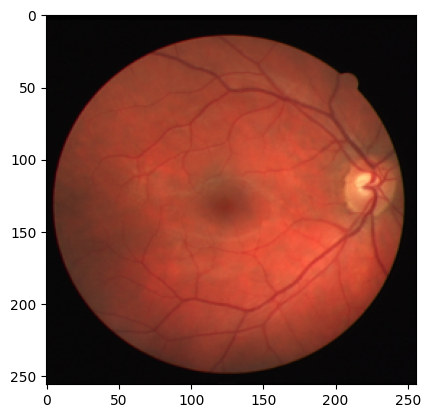

In [7]:
plt.imshow(drive_train[10]['image'].permute(1,2,0))
plt.show()

In [50]:
train_loader = data.DataLoader(ph2_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

In [57]:
def show_batch_seg(data_loader, batch_size, max_num=1):
    for idx, sample in enumerate(data_loader):
        images, labels = sample['image'], sample['label']

        fig = plt.figure(figsize=(18,6))
        fig.suptitle(f'Batch {idx}')
        for i in range(BATCH_SIZE):
            plt.subplot(2, 6, i+1)
            plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

            plt.subplot(2, 6, i+7)
            plt.imshow(labels[i].squeeze())
        plt.show()
        if max_num == idx+1:
            break


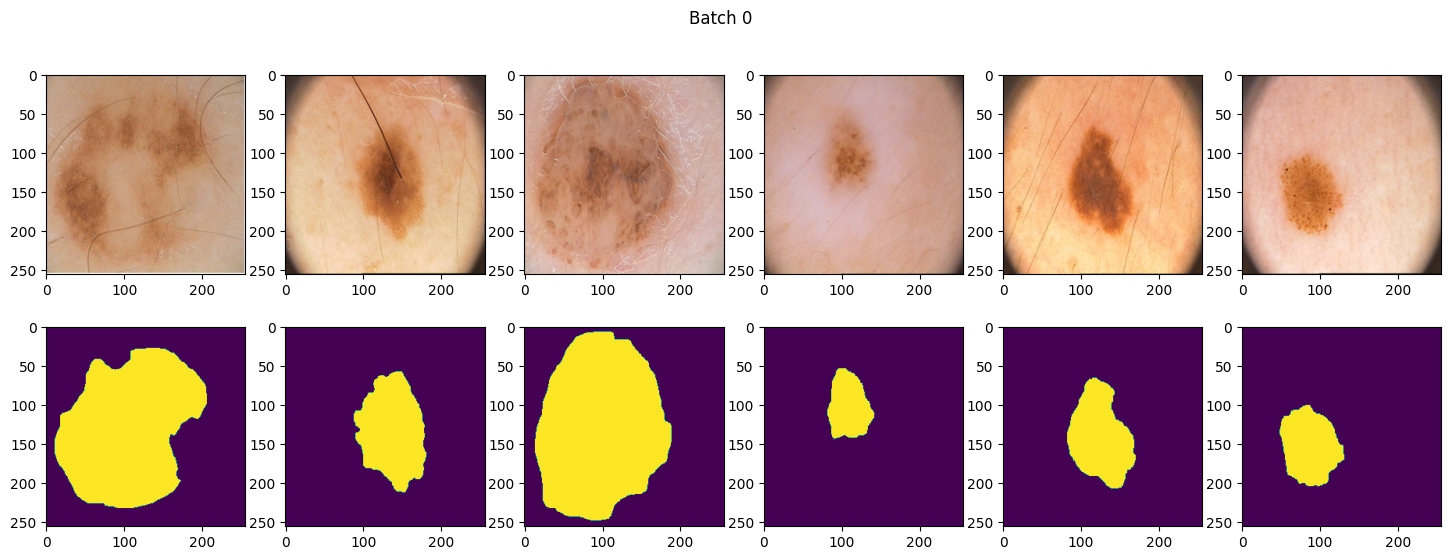

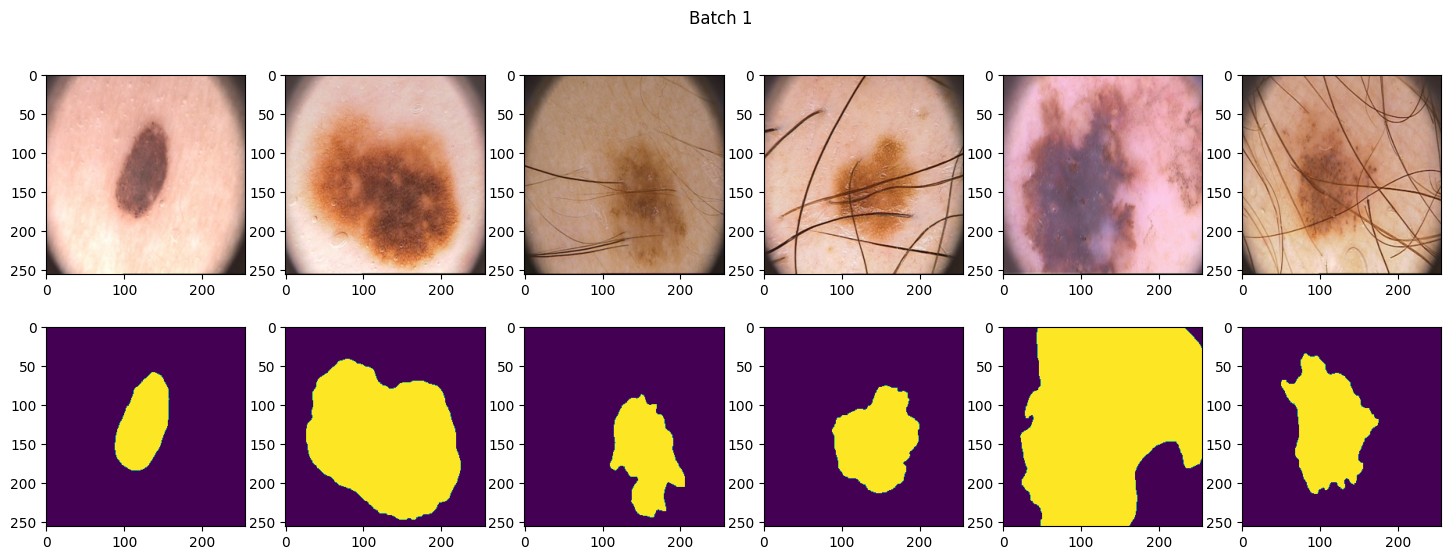

In [58]:
show_batch_seg(train_loader, BATCH_SIZE, 2)

# Metrics

In [ ]:
def bce_loss(target, pred):
    return torch.mean(pred - target*pred + torch.log(1 + torch.exp(-pred)))

def bce_loss_adjusted(target, pred):
    eps = 1e-7
    pred = torch.clamp(pred, eps, 1 - eps)
    return bce_loss(target, pred)

def dice_loss(target, pred):
    return 1 - torch.mean(2 * target * pred + 1) / (torch.mean(target + pred) + 1)

def iou_loss(target, pred):
    intersection = (pred & target).float().sum((1,2))
    union = (pred | target).float().sum((1,2))
    iou = intersection / union
    return 1 - iou.mean()

def accuracy(target, pred):
    pred = torch.argmax(pred, dim=1)
    correct = (pred == target).sum().item()
    return correct / target.numel()


def sensitivity(target, pred):
    pred = torch.argmax(pred, dim=1)
    num_classes = len(torch.unique(target))

    conf_matrix = torch.zeros(num_classes, num_classes)

    for t, p in zip(target.view(-1), pred.view(-1)):
        conf_matrix[t.long(), p.long()] += 1

    # Compute the true positives, true negatives, false positives and false negatives
    tp = conf_matrix[1][1]
    fn = conf_matrix[1][0]

    sensitivity = tp / (tp + fn)
    
    return sensitivity


def specifity(target, pred):
    pred = torch.argmax(pred, dim=1)
    num_classes = len(torch.unique(target))

    conf_matrix = torch.zeros(num_classes, num_classes)

    for t, p in zip(target.view(-1), pred.view(-1)):
        conf_matrix[t.long(), p.long()] += 1

    # Compute the true positives, true negatives, false positives and false negatives
    tn = conf_matrix[0][0]
    fp = conf_matrix[0][1]

    specifity = tn / (tn + fp)

    return specifity

In [65]:
def double_conv(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=channels_out),
        nn.ReLU(inplace=True),
        nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=channels_out),
        nn.ReLU(inplace=True),
    )


class SegNet(nn.Module):
    def __init__(self, params):
        super().__init__()

        C_in = params['channels']

        self.enc_conv0 = double_conv(C_in,32)

        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128

        self.enc_conv1 = double_conv(32,64)
        self.pool1 =   nn.MaxPool2d(2) # 128 -> 64
        self.enc_conv2 = double_conv(64,128)
        self.pool2 =   nn.MaxPool2d(2) # 64 -> 32
        self.enc_conv3 =  double_conv(128,256)
        self.pool3 =  nn.MaxPool2d(2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = double_conv(256,256)

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 16 -> 32
        self.dec_conv0 = double_conv(256,128)
        self.upsample1 =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)   # 32 -> 64
        self.dec_conv1 = double_conv(128,64)
        self.upsample2 =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 64 -> 128
        self.dec_conv2 = double_conv(64,32)
        self.upsample3 =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=1
        )
    
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        x= self.pool0(e0)
        e1 = self.enc_conv1(x)
        x= self.pool1(e1)
        e2 = self.enc_conv2(x)
        x= self.pool2(e2)
        e3 = self.enc_conv3(x)
        x= self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(x)

        # decoder
        d0 = self.upsample0(x)
        x = self.dec_conv0(d0)
        d1 = self.upsample1(x)
        x = self.dec_conv1(d1)
        d2 =  self.upsample2(x)
        x = self.dec_conv2(d2)
        d3 =  self.upsample3(x)
        
        out = self.dec_conv3(d3) # no activation
        return out

10
